In [1]:
import glob
import json
import pandas as pd
import datetime
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

In [2]:
# gets every log from directory
all_logs = glob.glob("../logs/*.json")

In [3]:
# formats all logs properly 
# key = session ID
# value = json w/ same format as what was originally held in nb metadata
formatted_logs = {}

for log in all_logs:
    f = open(log, 'r')
    
    # merges body sent from various HTTP Posts
    entries = f.read().split('}{')
    for i in range(len(entries)):
        entries[i] = '{' + entries[i] + '}'
    entries[0] = entries[0][1:]
    entries[-1] = entries[-1][:-1]
    formatted_log = json.loads(entries[0])
    for i in range(1,len(entries)):
        j = json.loads(entries[i])
        history = j['history']
        formatted_log['history'].extend(history)
    
    # get time user started ipynb
    formatted_log['startTime'] = formatted_log['history'][0]['time']
    formatted_log['endTime'] = formatted_log['history'][len(formatted_log['history'])-1]['time']
    
    # separates user hash from file name (sessionID)
    names = log.split('_')
    formatted_log['userHash'] = names[0][5:]
    
    # excluding Jerry and Doris and potentially others
    exclude_list = ['bca87887a1cc89312f7d073fd007ea68', '1a735d0ee6a6f9d7fdab573b50851da7']
    if names[0][5:] not in exclude_list:
        formatted_logs[names[1][:-5]] = formatted_log


In [4]:
df = pd.DataFrame(formatted_logs).transpose().sort_values('userHash')

In [5]:
df

,nbName,history,startTime,endTime,userHash
czxswqqjy,1-specifying-intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-27T02:41:41.804Z,2020-12-27T03:01:14.187Z,gs/003724cc5e41a981d3fad0ca3f21888d
6b6nhxtxh,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-27T01:20:56.927Z,2020-12-27T01:47:49.232Z,gs/003724cc5e41a981d3fad0ca3f21888d
8pzgwyy22,1-specifying-intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-27T03:02:30.953Z,2020-12-27T03:12:26.956Z,gs/003724cc5e41a981d3fad0ca3f21888d
ug7hr39o8,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-30T05:36:43.016Z,2020-11-30T06:11:08.975Z,gs/003a65e7008e9f7db64a6559970f962c
97vczg8cn,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-03T02:55:46.498Z,2020-12-03T03:12:19.732Z,gs/006b045214badd8a59f7f11c1eae488c
...,...,...,...,...,...
ku8fm3jm6,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04T21:56:31.543Z,2020-11-04T22:14:47.763Z,gs/fc836b6c537cc69b6eb6ab9cb7cb6b05
ak5h0c64n,4-Data-Playground.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04T22:20:55.715Z,2020-11-04T22:53:09.488Z,gs/fc836b6c537cc69b6eb6ab9cb7cb6b05
o995ki32j,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-01T06:17:35.472Z,2020-12-01T06:34:09.014Z,gs/fe50a4ea1e132d4d505b7941f1f48ef0
jiklvm3yu,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-25T16:37:15.015Z,2020-12-25T17:06:12.739Z,gs/feba0e7c024be16c21b46a6257a10367


In [6]:
# Number of unique IPs data was sent from
df['userHash'].nunique()

297

In [7]:
# Creates userGroups based on when notebook was first used
def groupDate(x):
    if x['startTime'].date() <= datetime.date(2020, 11, 1):
        return 'RiseCamp'
    elif x['startTime'].date() > datetime.date(2020, 11, 3) and x['startTime'].date() <= datetime.date(2020, 11, 5):
        return 'USF'
    else:
        return 'Other'
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])
df['userGroup'] = df.apply(groupDate, axis=1)
df = df.sort_values('startTime')

In [8]:
df.sort_values('userGroup')

,nbName,history,startTime,endTime,userHash,userGroup
iyil4wrfu,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-01 18:23:11.081000+00:00,2020-12-01 18:36:50.879000+00:00,gs/d4e40786f1f6a012751b6c74af557ed3,Other
vuvpd4f1p,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-11 17:32:02.107000+00:00,2020-12-11 17:32:02.107000+00:00,gs/e2a103c953bb2855fa9a9a65403fb398,Other
akmlvvf83,0-overview.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-11 16:29:09.130000+00:00,2020-12-11 16:31:42.471000+00:00,gs/22667b072c8356ba93eb9a6eec12785b,Other
uoon1c0qg,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-11 14:03:25.227000+00:00,2020-12-11 14:04:18.080000+00:00,gs/65966ee950664ba12457c2d8f18d38e6,Other
dzk4gb5nr,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-12-...",2020-12-10 22:27:39.998000+00:00,2020-12-10 22:29:04.529000+00:00,gs/bca87887a1cc89312f7d073fd007ea68,Other
...,...,...,...,...,...,...
m2xc6ec08,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:52:17.359000+00:00,2020-11-04 22:01:28.290000+00:00,gs/52dacd9e8e026c076c886a89c4a84b9a,USF
q7onw2fq2,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:53:17.697000+00:00,2020-11-04 22:06:48.111000+00:00,gs/aea7f8e69322a459e5639238c290c57e,USF
ku8fm3jm6,2-Quick-Vis.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:56:31.543000+00:00,2020-11-04 22:14:47.763000+00:00,gs/fc836b6c537cc69b6eb6ab9cb7cb6b05,USF
tih262tu7,1-Specify-Intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-11-...",2020-11-04 21:30:57.767000+00:00,2020-11-04 21:52:03.823000+00:00,gs/aea7f8e69322a459e5639238c290c57e,USF


In [9]:
nb_map = {}
nbs = df[df['userGroup'] == 'Other']
for nb in nbs['nbName']: 
    if nb in nb_map:
        nb_map[nb] += 1
    else:
        nb_map[nb] = 1
nb_map

{'6-index-group.ipynb': 4,
 '4-Data-Playground.ipynb': 4,
 '1-Specify-Intent.ipynb': 4,
 '0-Lux-Overview.ipynb': 1,
 'cars_demo.ipynb': 313,
 '3-widget-vis-export.ipynb': 8,
 '3-Export-Widget.ipynb': 4,
 '1-specifying-intent.ipynb': 13,
 '4-chart-settings.ipynb': 7,
 '5-datetime.ipynb': 9,
 '7-formal-definition.ipynb': 4,
 '0-overview.ipynb': 24,
 '2-Quick-Vis.ipynb': 3,
 'college_demo.ipynb': 6,
 '.ipynb': 1,
 '2-constructing-vis-and-vislist.ipynb': 5,
 '8-custom-action.ipynb': 1,
 'exploratory_demo.ipynb': 3}

In [10]:
len(nbs)

414

In [11]:
diff = nbs['endTime'] - nbs['startTime']
diff = [x.total_seconds()%3600 / 60 for x in diff]

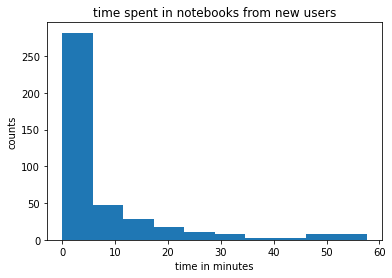

In [12]:
plt.hist(diff)
plt.xlabel("time in minutes")
plt.ylabel('counts')
plt.title('time spent in notebooks from new users')
plt.show()



In [13]:
def has_0(nbNames):
    for nbName in nbNames:
        if '0' in nbName:
            return 1
    return 0
def has_1(nbNames):
    for nbName in nbNames:
        if '1' in nbName:
            return 1
    return 0
def has_2(nbNames):
    for nbName in nbNames:
        if '2' in nbName:
            return 1
    return 0
def has_3(nbNames):
    for nbName in nbNames:
        if '3' in nbName:
            return 1
    return 0
def has_4(nbNames):
    for nbName in nbNames:
        if '4' in nbName:
            return 1
    return 0

In [14]:
# Groups users by hash and computes information as to whether user attempt notebook
grouped_df = df.groupby('userHash').agg(userGroup=('userGroup', sp.mode), startTime=('startTime', 'min'), endTime=('endTime', 'max'), 
                                        tried_0=('nbName', has_0), tried_1=('nbName', has_1), tried_2=('nbName', has_2),
                                        tried_3=('nbName', has_3), tried_4=('nbName', has_4))
grouped_df['userGroup'] = grouped_df['userGroup'].apply(lambda x: x[0][0])
grouped_df.sort_values('startTime')

,userGroup,startTime,endTime,tried_0,tried_1,tried_2,tried_3,tried_4
userHash,,,,,,,,
gs/bca87887a1cc89312f7d073fd007ea68,Other,2020-10-30 04:38:02.270000+00:00,2021-02-13 03:18:31.902000+00:00,1,1,0,1,1
gs/1a735d0ee6a6f9d7fdab573b50851da7,RiseCamp,2020-10-30 11:14:12.703000+00:00,2020-11-04 03:30:52.624000+00:00,0,1,1,1,1
gs/e0157f975b2aecbe652c4706db61a112,RiseCamp,2020-10-30 20:50:55.802000+00:00,2020-11-13 03:27:19.899000+00:00,1,1,1,1,1
gs/46c3fa396f1071a92372dc40078b42f0,RiseCamp,2020-10-30 21:23:52.207000+00:00,2020-10-30 22:28:26.332000+00:00,0,1,1,1,0
gs/a8c4ac0672f0751b58b4738ef4488877,RiseCamp,2020-10-30 21:36:27.644000+00:00,2020-10-30 22:29:35.339000+00:00,0,1,1,1,1
...,...,...,...,...,...,...,...,...
gs/d1a4438898d94b71996e8bfeb64e5cd4,Other,2021-02-10 10:08:12.832000+00:00,2021-02-10 10:08:32.305000+00:00,0,0,0,0,0
gs/73bec3c28174f8d73abdfa328c411610,Other,2021-02-10 22:56:13.858000+00:00,2021-02-10 22:58:14.650000+00:00,0,0,0,0,0
gs/cdf0e3fa6707f62d73cf4fa757772e71,Other,2021-02-11 08:34:37.400000+00:00,2021-02-11 08:39:56.295000+00:00,0,0,0,0,0


In [15]:
grouped_df.groupby("userGroup").count()

,startTime,endTime,tried_0,tried_1,tried_2,tried_3,tried_4
userGroup,,,,,,,
Other,274,274,274,274,274,274,274
RiseCamp,12,12,12,12,12,12,12
USF,11,11,11,11,11,11,11


In [16]:
# Plots user attemps at tutorial notebooks
def plot_nb_progression(df, userGroup, n):
    nbNames = ['1-Specify-Intent.ipynb', '2-Quick-Vis.ipynb', '3-widget-vis-export.ipynb', '4-Data-Playground.ipynb'] 
    counts = [sum(df['tried_1']),sum(df['tried_2']),sum(df['tried_3']),sum(df['tried_4'])]
    plt.bar(nbNames , counts)
    plt.xticks(nbNames, rotation=45)
    plt.title(str(userGroup) + ' Attempts of Tutorial Notebooks n=' + str(n))
    plt.ylabel('Counts')
    plt.show()


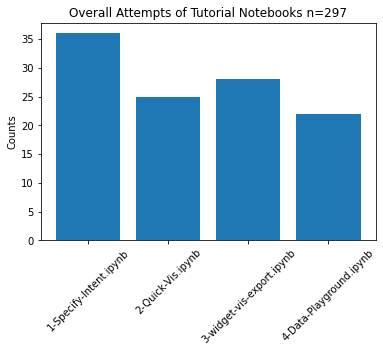

In [17]:
plot_nb_progression(grouped_df, 'Overall', len(grouped_df))

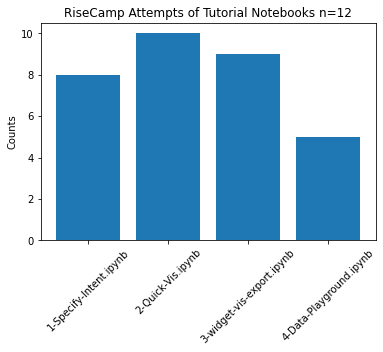

In [18]:
riseCamp_df = grouped_df[grouped_df['userGroup']=='RiseCamp']
plot_nb_progression(riseCamp_df, 'RiseCamp', len(riseCamp_df))

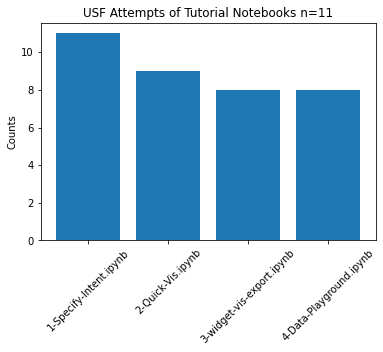

In [19]:
usf_df = grouped_df[grouped_df['userGroup']=='USF']
plot_nb_progression(usf_df, 'USF', len(usf_df))

In [20]:
# playground_df = df[df['nbName'] == '4-Data-Playground.ipynb']
playground_df = df

{'type': 'toggleBtnClick', 'time': '2020-10-30T20:52:50.179Z', 'param': 'pandas'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T20:52:52.137Z', 'param': 'lux'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T20:52:53.687Z', 'param': 'pandas'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T20:53:06.977Z', 'param': 'lux'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T20:55:01.909Z', 'param': 'pandas'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T20:55:09.785Z', 'param': 'lux'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T21:00:28.297Z', 'param': 'pandas'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T21:00:28.912Z', 'param': 'lux'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T21:00:34.396Z', 'param': 'pandas'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T21:01:16.393Z', 'param': 'lux'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T21:24:52.106Z', 'param': 'pandas'}
{'type': 'toggleBtnClick', 'time': '2020-10-30T21:24:52.801Z', 'param': 'lux'}
{'type': 'toggleBtnClick', 'time':

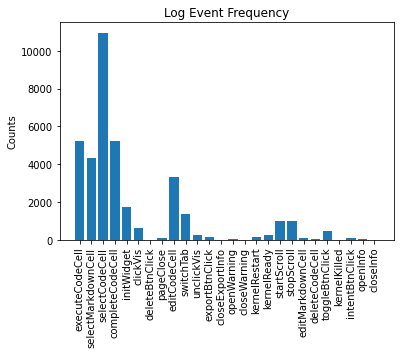

In [21]:
# takes care of scrolling issue where if they stop scrolling for a moment, it treats as separate scrolls

function_freq = {}
timing = {}
for log in playground_df['history']:
    prev = ''
    for entry in log:
        if entry['type'] == 'toggleBtnClick':
            print(entry)
        if 'stopScroll' not in prev:
            if entry['type'] in function_freq.keys():
                function_freq[entry['type']] += 1
            else:
                function_freq[entry['type']] = 1
        prev = entry['type']
        
function_freq['stopScroll'] = function_freq['startScroll']
function_freq['initWidget'] = function_freq['initWidget']/2
# del function_freq['selectCodeCell']
plt.bar(function_freq.keys(), function_freq.values())
plt.xticks(list(function_freq.keys()), rotation=90)
plt.title('Log Event Frequency')
plt.ylabel('Counts')
plt.show()
        

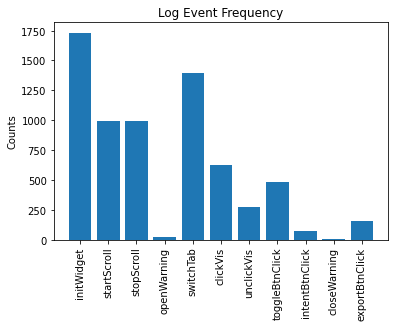

In [22]:
lux_events = ['initWidget', 'startScroll', 'stopScroll', 'openWarning', 'switchTab', 'clickVis', 'unclickVis', 'toggleBtnClick', 'intentBtnClick', 'closeWarning', 'exportBtnClick']
lux_values = []
for event in lux_events:
    lux_values.append(function_freq[event])
    
plt.bar(lux_events, lux_values)
plt.xticks(lux_events, rotation=90)
plt.title('Log Event Frequency')
plt.ylabel('Counts')
plt.show()
          

In [23]:
playground_df['endTime'] - playground_df['startTime']

dpgpv1uut   0 days 00:02:54.474000
fxkya0j2o   0 days 00:00:19.185000
2qh1rxgwk   0 days 00:01:11.753000
01e3vz4rh   0 days 00:12:47.412000
a7kawfmt0   0 days 00:48:12.455000
                     ...          
7o9g3hpjx   0 days 00:21:47.164000
v664iivlb   0 days 00:05:24.845000
i9hyz1hk6   0 days 00:00:08.267000
rqt8hxtt8   0 days 00:00:09.931000
t12wz6rk4   0 days 02:11:43.474000
Length: 514, dtype: timedelta64[ns]

In [24]:
grouped_df.reset_index().drop(columns=["startTime","endTime"]).to_csv("user_groups.csv",index=None)

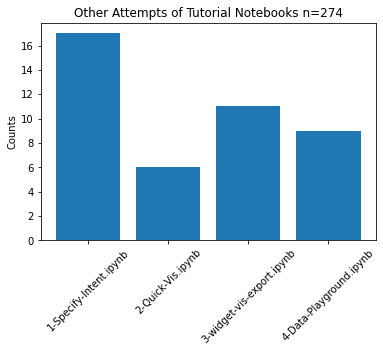

In [25]:
other_df = grouped_df[grouped_df['userGroup']=='Other']
plot_nb_progression(other_df, 'Other', len(other_df))

In [26]:
other_df

,userGroup,startTime,endTime,tried_0,tried_1,tried_2,tried_3,tried_4
userHash,,,,,,,,
gs/003724cc5e41a981d3fad0ca3f21888d,Other,2020-12-27 01:20:56.927000+00:00,2020-12-27 03:12:26.956000+00:00,0,1,0,0,0
gs/003a65e7008e9f7db64a6559970f962c,Other,2020-11-30 05:36:43.016000+00:00,2020-11-30 06:11:08.975000+00:00,0,0,0,0,0
gs/006b045214badd8a59f7f11c1eae488c,Other,2020-12-03 02:55:46.498000+00:00,2020-12-03 03:12:19.732000+00:00,0,0,0,0,0
gs/00ae885f453834201f83376bcfddd31a,Other,2020-11-30 07:02:30.883000+00:00,2020-11-30 07:02:53.966000+00:00,0,0,0,0,0
gs/040b920fcc03cbc13e159b961d57263f,Other,2020-12-01 08:39:38.863000+00:00,2020-12-01 08:53:22.688000+00:00,0,0,0,0,0
...,...,...,...,...,...,...,...,...
gs/f71ce89ba4ad8e825f6651f7d33821cb,Other,2021-01-28 14:10:59.517000+00:00,2021-01-28 14:11:55.801000+00:00,0,0,0,0,0
gs/f920d5c664474a7f2b0e4aef22dc1e60,Other,2020-12-24 13:18:46.572000+00:00,2020-12-24 13:41:37.082000+00:00,0,0,0,0,0
gs/fe50a4ea1e132d4d505b7941f1f48ef0,Other,2020-12-01 06:17:35.472000+00:00,2020-12-01 06:34:09.014000+00:00,0,0,0,0,0


## Computing Time until Toggle and Time in Each Tab

In [27]:
df['history'][1]

[{'type': 'executeCodeCell',
  'time': '2020-10-30T04:43:40.409Z',
  'code': '# Collecting basic usage statistics for Lux (For more information, see: https://tinyurl.com/logging-consent)\nlux.logger = True # Remove this line if you do not want your interactions recorded',
  'id': '89444c09fc5b47659e5b00505a4bb0c6',
  'order_count': 2},
 {'type': 'selectMarkdownCell',
  'time': '2020-10-30T04:43:40.417Z',
  'code': 'We first load in the [Cars dataset](http://lib.stat.cmu.edu/datasets/) with 392 different cars from 1970-1982, which contains information about its Horsepower, MilesPerGal, Acceleration, etc.',
  'id': 'fcce4eae9ae4448abe9efa373296d229',
  'order_count': 3},
 {'type': 'selectCodeCell',
  'time': '2020-10-30T04:43:40.591Z',
  'code': 'df = pd.read_csv("../data/car.csv")\ndf["Year"] = pd.to_datetime(df["Year"], format=\'%Y\') # change pandas dtype for the column "Year" to datetype',
  'id': 'fe2dfdf3090440b28c18b6a9f1fcf594',
  'order_count': 4},
 {'type': 'executeCodeCell',
 

In [28]:
def get_toggles(history):
    count = 0
    for entry in history:
        if entry['type'] == 'initWidget':
            count += 1
    return count // 2

def get_times_until_toggle(history):
    times = []
    for i in range(len(history)):
        if history[i]['type'] == 'initWidget' and history[i-1]['type'] == 'initWidget':
            j=i-2
            while j>=0:
                if history[j]['type'] != 'completeCodeCell':
                    j-=1
                elif history[j]['isPrintPandasDf'] != True:
                    j-=1
                else:
                    break
            if j != -1:
                timeDiff = pd.to_datetime(history[i-1]['time']) - pd.to_datetime(history[j]['time'])
                times.append(timeDiff.total_seconds())
            else:
                times.append(0)
    return times

def get_first_switch_time(history):
    times = []
    for i in range(len(history)):
        if history[i]['type'] == 'initWidget' and history[i-1]['type'] == 'initWidget':
            j=i+1
            while j<len(history) and history[j]['type'] != 'switchTab':
                j+=1
            if j < len(history):
                timeDiff = pd.to_datetime(history[j]['time']) - pd.to_datetime(history[i-1]['time'])
                times.append(timeDiff.total_seconds())
            else:
                times.append(0)
    return times

In [29]:
df['initWidgetCount'] = df['history'].apply(get_toggles)
df['timeUntilWidgitInit'] = df['history'].apply(get_times_until_toggle)
df['timeUntilFirstSwitchTab'] = df['history'].apply(get_first_switch_time)

In [30]:
time_df = df[['nbName','history','userGroup','initWidgetCount', 'timeUntilWidgitInit', 'timeUntilFirstSwitchTab']]
time_df

,nbName,history,userGroup,initWidgetCount,timeUntilWidgitInit,timeUntilFirstSwitchTab
dpgpv1uut,0-Lux-Overview.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,1,[3.049],[0]
fxkya0j2o,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,1,[1.237],[0]
2qh1rxgwk,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,2,"[4.083, 3.105]","[29.22, 4.378]"
01e3vz4rh,1-Specify-Intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,2,"[0, 15.098]","[0, 0]"
a7kawfmt0,1-Specify-Intent.ipynb,"[{'type': 'executeCodeCell', 'time': '2020-10-...",RiseCamp,6,"[0, 0, 0, 0, 0, 0]","[14.037, 195.457, 103.774, 41.585, 15.578, 0]"
...,...,...,...,...,...,...
7o9g3hpjx,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,1,[1.073],[0]
v664iivlb,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,2,"[1.707, 57.686]","[23.374, 0]"
i9hyz1hk6,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,1,[1.949],[0]
rqt8hxtt8,cars_demo.ipynb,"[{'type': 'executeCodeCell', 'time': '2021-02-...",Other,1,[1.076],[0]


In [31]:
sum(df['initWidgetCount']) / len(df['initWidgetCount'])

3.301556420233463

In [32]:
def get_avg_non_zero(lst):
    count = 0
    total = 0
    for elem in lst:
        if elem != 0:
            count += 1
            total += elem
    return total/count

In [33]:
widgitInit = list(np.concatenate(df['timeUntilWidgitInit']).flat)
print(sum(widgitInit) / len(widgitInit))
print(get_avg_non_zero(widgitInit))

28.877556859867926
40.49394032921809


In [42]:
print(np.percentile(widgitInit, 90))

55.49539999999993


In [41]:
switchTimes = list(np.concatenate(df['timeUntilFirstSwitchTab']).flat)
print(get_avg_non_zero(switchTimes))


172.28305223880614


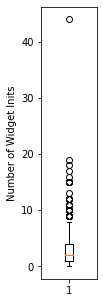

In [35]:
plt.figure(figsize=(1, 5))
plt.boxplot(df['initWidgetCount'])
plt.ylabel("Number of Widget Inits")
plt.show()

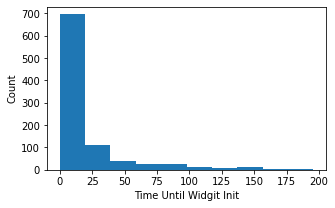

In [36]:
non_zero = list(filter(lambda x: x!=0, widgitInit))
non_zero_truncated = list(filter(lambda x: x < 200, non_zero))
plt.figure(figsize=(5, 3))
plt.hist(non_zero_truncated)
plt.xlabel("Time Until Widgit Init")
plt.ylabel("Count")
plt.show()

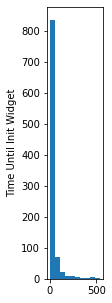

In [37]:
truncated_widgit_init = list(filter(lambda x: x != 0 and x < 3*np.std(widgitInit), widgitInit))
plt.figure(figsize=(1, 5))
plt.hist(truncated_widgit_init)
plt.ylabel("Time Until Init Widget")
plt.show()

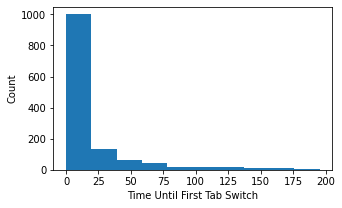

In [38]:
plt.figure(figsize=(5, 3))
truncated_switchTimes = list(filter(lambda x: x < 200, switchTimes))
plt.hist(truncated_switchTimes)
plt.xlabel("Time Until First Tab Switch")
plt.ylabel("Count")
plt.show()